<a href="https://colab.research.google.com/github/shoaibsattar823/CS893-Semantic-Segmentation/blob/master/segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
cd drive/My\ Drive/Advanced\ Computer\ Vision\ (\CS\ 893)\/Assignment3

/content/drive/My Drive/Advanced Computer Vision (CS 893)/Assignment3


In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import tqdm, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

%tensorflow_version 1.x
import tensorflow as tf

import keras
from keras.models import Model, load_model
from keras.layers import Layer, ZeroPadding2D, Cropping2D
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K

In [0]:
# Set some parameters
im_width = 256
im_height = 256

In [0]:
"""
This function can be used to read the images from the dataset created by the patchify_dataset.py.
Example Usage:
X_test, y_test = get_images("ModMonuSeg/Test/", (im_width, im_height), gt_extension='png')
"""
def get_images(parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
  tissue_dir = parent_dir + img_folder
  gt_dir = parent_dir + gt_folder

  im_width, im_height = im_shape


  ids = next(os.walk(tissue_dir))[2]
  print("No. of images = ", len(ids))

  X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
  y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

  # tqdm is used to display the progress bar
  for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(tissue_dir+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0]
    mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
    if gt_extension:
      mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
    mask = img_to_array(load_img(gt_dir+mask_id_, color_mode='grayscale'))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  return X, y

In [6]:
# from image_io import get_images as get_images
X_train, y_train = get_images('ModMonuSeg/Training/', (im_width, im_height), gt_extension='png')
X_test, y_test = get_images('ModMonuSeg/Test/', (im_width, im_height), gt_extension='png')

No. of images =  1080



No. of images =  504


In [0]:
# Creating Train Validation Split
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train, y_train,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        shuffle=True)

##### Defining some performance measures for network training

In [0]:
# Dice Score
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# F1 Score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##### Defining methods for Segnet Model

In [0]:
class MaxPoolingWithIndices(keras.layers.Layer):
    def __init__(self, pool_size,strides,padding='SAME',**kwargs):
        super(MaxPoolingWithIndices, self).__init__(**kwargs)
        self.pool_size=pool_size
        self.strides=strides
        self.padding=padding
        return
    def call(self,x):
        pool_size=self.pool_size
        strides=self.strides
        if isinstance(pool_size,int):
            ps=[1,pool_size,pool_size,1]
        else:
            ps=[1,pool_size[0],pool_size[1],1]
        if isinstance(strides,int):
            st=[1,strides,strides,1]
        else:
            st=[1,strides[0],strides[1],1]
        output1,output2=tf.nn.max_pool_with_argmax(x,ps,st,self.padding)
        return [output1,output2]
    def compute_output_shape(self, input_shape):
        if isinstance(self.pool_size,int):
            output_shape=(input_shape[0],input_shape[1]//self.pool_size,input_shape[2]//self.pool_size,input_shape[3])
        else:
            output_shape=(input_shape[0],input_shape[1]//self.pool_size[0],input_shape[2]//self.pool_size[1],input_shape[3])
        return [output_shape,output_shape]


class UpSamplingWithIndices(Layer):
    def __init__(self, **kwargs):
        super(UpSamplingWithIndices, self).__init__(**kwargs)
        return
    def call(self,x):
        argmax=K.cast(K.flatten(x[1]),'int32')
        max_value=K.flatten(x[0])
        with tf.variable_scope(self.name):
            input_shape=K.shape(x[0])
            batch_size=input_shape[0]
            image_size=input_shape[1]*input_shape[2]*input_shape[3]
            output_shape=[input_shape[0],input_shape[1]*2,input_shape[2]*2,input_shape[3]]
            indices_0=K.flatten(tf.matmul(K.reshape(tf.range(batch_size),(batch_size,1)),K.ones((1,image_size),dtype='int32')))
            indices_1=argmax%(image_size*4)//(output_shape[2]*output_shape[3])
            indices_2=argmax%(output_shape[2]*output_shape[3])//output_shape[3]
            indices_3=argmax%output_shape[3]
            indices=tf.stack([indices_0,indices_1,indices_2,indices_3])
            output=tf.scatter_nd(K.transpose(indices),max_value,output_shape)
            return output
    def compute_output_shape(self, input_shape):
        return input_shape[0][0],input_shape[0][1]*2,input_shape[0][2]*2,input_shape[0][3]

def CompositeConv(inputs,num_layers,num_features):
    output=inputs
    if isinstance(num_features,int):
        for i in range(num_layers):
            output=Conv2D(num_features,(7,7),padding='same')(output)
            output=BatchNormalization(axis=3)(output)
            output=Activation('relu')(output)
        return output
    for i in range(num_layers):
        output=Conv2D(num_features[i],(7,7),padding='same')(output)
        output=BatchNormalization(axis=3)(output)
        output=Activation('relu')(output)
    return output

##### Creating the Model

In [10]:
inputs=Input(shape=(256,256,3))

x = ZeroPadding2D(((16,16),(16,16)))(inputs)

x=CompositeConv(x,2,64)
x,argmax1=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,2,64)
x,argmax2=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,3,64)
x,argmax3=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,3,64)
x,argmax4=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,3,64)
x,argmax5=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=UpSamplingWithIndices()([x,argmax5])
x=CompositeConv(x,3,64)

x=UpSamplingWithIndices()([x,argmax4])
x=CompositeConv(x,3,64)

x=UpSamplingWithIndices()([x,argmax3])
x=CompositeConv(x,3,64)

x=UpSamplingWithIndices()([x,argmax2])
x=CompositeConv(x,2,64)

x=UpSamplingWithIndices()([x,argmax1])
x=CompositeConv(x,2,[64,1])

x=Activation('sigmoid')(x)

y=Cropping2D(((16,16),(16,16)))(x)


model=Model(inputs=inputs,outputs=y)

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 288, 288, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 288, 288, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 288, 288, 64) 256         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('segnet-model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [13]:
# Compiling the model
EPOCHS = 50
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', dice_coef, f1])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Defining a Data Generator for loading data in batches
BS = 16
datagen = ImageDataGenerator()
train_gen = datagen.flow(X_train, y_train, batch_size=BS)
valid_gen = datagen.flow(X_valid, y_valid, batch_size=BS)

In [15]:
# Training the network
import math
train_size = len(X_train)
valid_size = len(X_valid)
train_steps = math.ceil(train_size/BS)
valid_steps = math.ceil(valid_size/BS)
H = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=50,
                        validation_data=valid_gen, validation_steps=valid_steps,
                        )
model.save('segnet-model.h5')



Epoch 1/50
54/54 [==============================] - 80s 1s/step - loss: 0.6875 - acc: 0.6513 - dice_coef: 0.3902 - f1: 0.5795 - val_loss: 0.6897 - val_acc: 0.5758 - val_dice_coef: 0.3767 - val_f1: 0.5218
Epoch 2/50
54/54 [==============================] - 64s 1s/step - loss: 0.6521 - acc: 0.8292 - dice_coef: 0.4342 - f1: 0.6847 - val_loss: 0.7846 - val_acc: 0.3703 - val_dice_coef: 0.4079 - val_f1: 0.4375
Epoch 3/50
54/54 [==============================] - 64s 1s/step - loss: 0.6483 - acc: 0.8373 - dice_coef: 0.4420 - f1: 0.6957 - val_loss: 0.9914 - val_acc: 0.3264 - val_dice_coef: 0.4134 - val_f1: 0.4261
Epoch 4/50
54/54 [==============================] - 65s 1s/step - loss: 0.6460 - acc: 0.8410 - dice_coef: 0.4438 - f1: 0.7006 - val_loss: 1.1338 - val_acc: 0.3180 - val_dice_coef: 0.4197 - val_f1: 0.4323
Epoch 5/50
54/54 [==============================] - 64s 1s/step - loss: 0.6422 - acc: 0.8473 - dice_coef: 0.4502 - f1: 0.7195 - val_loss: 0.6954 - val_acc: 0.6766 - val_dice_coef: 0.

##### Plot Learning Curve

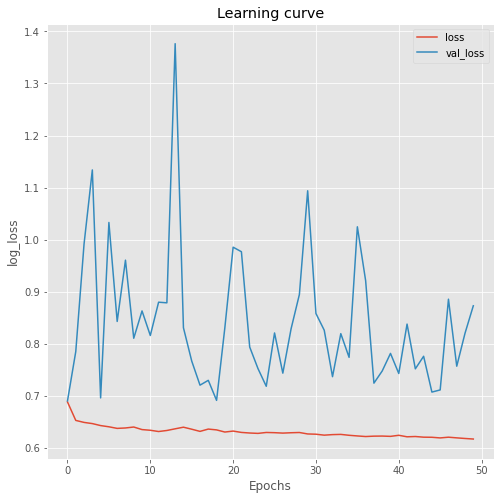

In [21]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(H.history["loss"], label="loss")
plt.plot(H.history["val_loss"], label="val_loss")
# plt.plot( np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

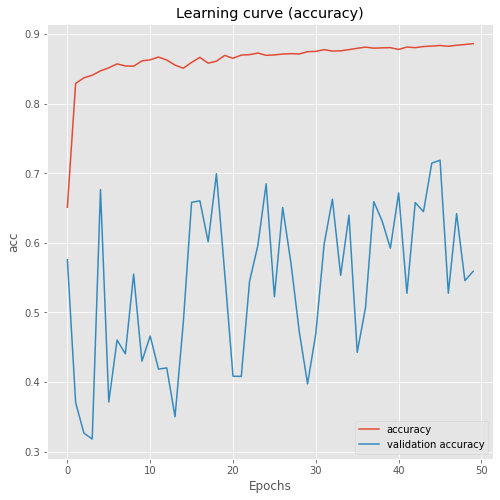

In [22]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve (accuracy)")
plt.plot(H.history["acc"], label="accuracy")
plt.plot(H.history["val_acc"], label="validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()

### Inference

In [23]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test, verbose=1)

504/504 [==============================] - 19s 38ms/step


[0.8200842161027212,
 0.5846811031538343,
 0.34710372960756697,
 0.4302521565603831]

In [24]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

504/504 [==============================] - 17s 33ms/step


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

##### Performance Visualization 

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Tissue')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Mask Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Mask Predicted binary');

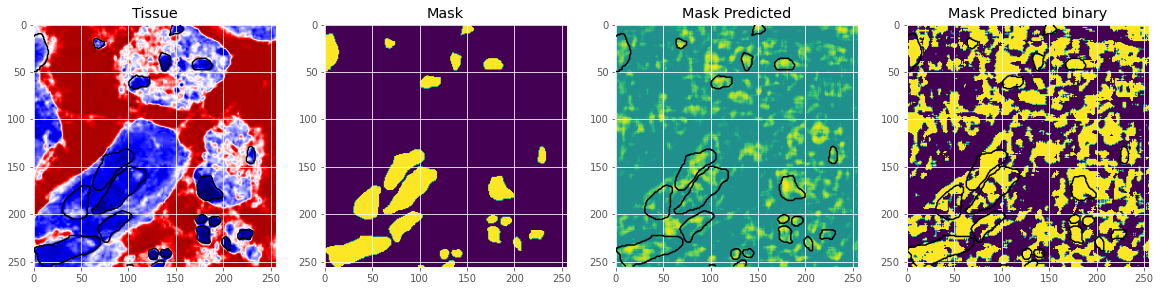

In [27]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

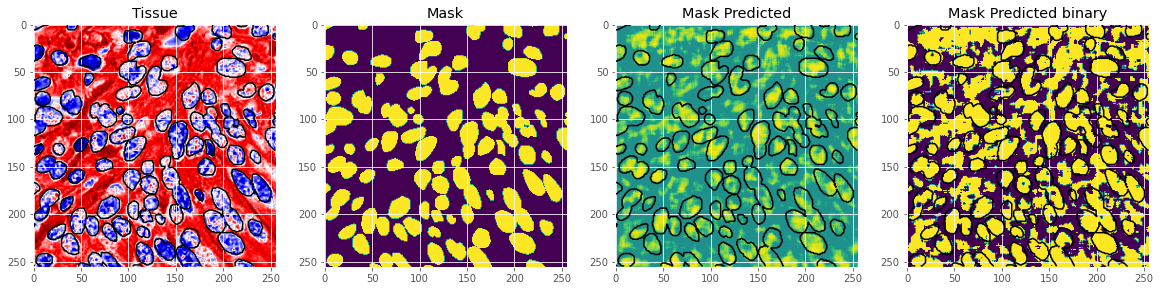

In [34]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=800)

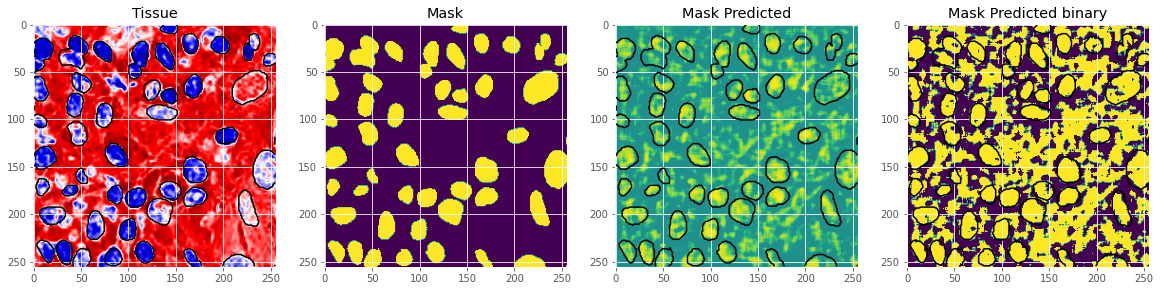

In [28]:
# Check performance on test data
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=14)

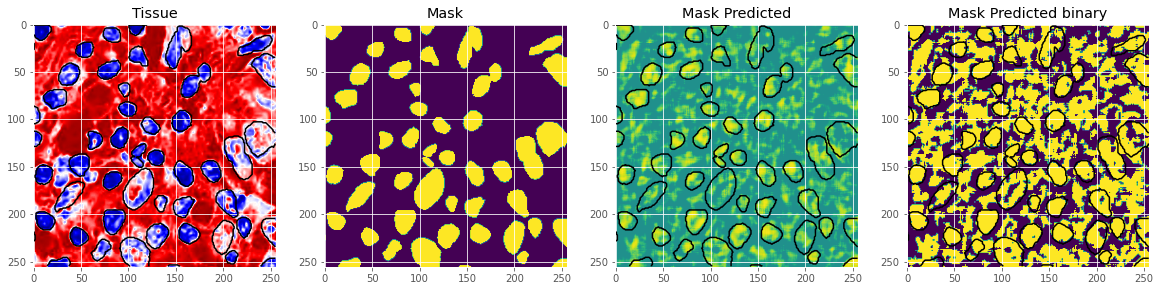

In [32]:
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=500)